# Libaries / Modules

In [1]:
import sys
import os
lib_dir = os.path.abspath(os.getcwd() + '/../../../class_tim')
if lib_dir not in sys.path:
    sys.path.append(lib_dir)

In [2]:
%cd $lib_dir

/informatik2/mobis/home/lueders/Desktop/Forschung/Research/LYNX/lynx/jupyter/class_tim


In [3]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import nltk
import gensim
from gensim.models import Word2Vec
from gensim.parsing.porter import PorterStemmer

stopWords = set(stopwords.words('english'))
stopWords = stopWords.union(set(['com', 'org', 'java']))

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
#Needed Modules
from sklearn import preprocessing
# import seaborn as sns
import re

import pandas as pd
import numpy as np

from tqdm import tqdm
 
import os
import sys
import random

import json
from pathlib import Path

import tensorflow as tf
import tensorflow_addons as tfa
import keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import CSVLogger
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sklearn.utils.class_weight
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# from plot_keras_history import plot_history
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Dense, BatchNormalization, Activation, Lambda, Flatten, Dropout, Conv1D, MaxPool1D, LSTM, GlobalMaxPooling1D, Concatenate, Bidirectional, Conv2D, Reshape, GlobalMaxPooling2D, MaxPooling2D

import matplotlib.pyplot as plt
from tensorflow.keras.backend import expand_dims, transpose

from links.data import LinkData

import cv2

from sklearn.preprocessing import LabelEncoder

print("Starting Notebook.")

Starting Notebook.


In [5]:
tqdm.pandas()

# Loading Data

In [6]:
!ls ../class_clara/experiments/Replication/results

apache_Duplicate_R_LTOLvNL_accauc.csv
apache_Duplicate_R_LTOLvNL_confmat.csv
apache_Duplicate_R_LTOLvNL_metrics.csv
apache_Duplicate_R_LTvNL_accauc.csv
apache_Duplicate_R_LTvNL_confmat.csv
apache_Duplicate_R_LTvNL_metrics.csv
apache_Duplicate_R_LTvNLOL_accauc.csv
apache_Duplicate_R_LTvNLOL_confmat.csv
apache_Duplicate_R_LTvNLOL_metrics.csv
apache_Duplicate_R_LTvOL_accauc.csv
apache_Duplicate_R_LTvOL_confmat.csv
apache_Duplicate_R_LTvOL_metrics.csv
DCCNN_acc.png
DCCNN_all_1.png
DCCNN_all.png
dccnn_apache_Duplication_R_LTOLvNL_accauc.csv
dccnn_apache_Duplication_R_LTOLvNL_confmat.csv
dccnn_apache_Duplication_R_LTOLvNL_metrics.csv
dccnn_apache_Duplication_R_LTvNL_accauc.csv
dccnn_apache_Duplication_R_LTvNL_confmat.csv
dccnn_apache_Duplication_R_LTvNL_metrics.csv
dccnn_apache_Duplication_R_LTvNLOL_accauc.csv
dccnn_apache_Duplication_R_LTvNLOL_confmat.csv
dccnn_apache_Duplication_R_LTvNLOL_metrics.csv
dccnn_apache_Duplication_R_LTvOL_accauc.csv
dccnn_apache_Duplication_R_LTvOL_confmat.csv
d

In [7]:
SOURCE = "secondlife"

# 'apache', 243k, 
# 'redhat', 106k
# 'jira', 98k

# 'mongodb', 38k
# 'qt', 36k

# 'sakai', 19k
# 'hyperledger', 16k 
# 'mariadb', 15k
# 'spring', 14k
# 'jiraecosystem', 11k

# 'sonatype', 4k, small
# 'jfrog', 3k, small
# 'inteldaos', 3k too small

# 'secondlife', 630 too small
# 'mindville', 44 too small

In [8]:
data = LinkData.from_tracker(SOURCE, 'stanza', add_non_links=False)

In [9]:
#Loading Issues & Links
issues = data._issue_df
print("Number of Issues: " + str(len(issues)))
print("Feature Size: " + str(len(list(issues.columns.values))))

filename = '../data/crawl3/clean_links_'+SOURCE.lower()+'.csv'
links = pd.read_csv(filename, encoding="UTF-8", low_memory=False, index_col=0)
print("Number of Links: " + str(len(links)))
print("Feature Size: "+str(len(list(links.columns.values))))

Number of Issues: 1865
Feature Size: 11
Number of Links: 630
Feature Size: 5


In [10]:
links.linktype.value_counts()

Subtask         314
Relates         185
Cloners          48
Parent/Child     41
Depends          28
Collection       14
Name: linktype, dtype: int64

In [11]:
type_dict={'Backports': 'Workflow', 
           
    'Blocked': 'Temporal/Causal',
    'Blocker': 'Temporal/Causal',
    'Blocks': 'Temporal/Causal',
           
    'Bonfire Testing': 'Workflow', 
    'Bonfire testing': 'Workflow', 
    'Git Code Review': 'Workflow', 
    'Testing': 'Workflow',
           
    'Causality': 'Temporal/Causal', 
    'Cause': 'Temporal/Causal',
    'Caused': 'Temporal/Causal', 
    'Problem/Incident': 'Temporal/Causal',
           
    'Child-Issue': 'Composition', 
    'Parent Feature': 'Composition',
    'Parent/Child': 'Composition',
    'multi-level hierarchy [GANTT]': 'Composition',
    'Parent-Relation': 'Composition',
           
    'Cloners': 'Duplication', 
    'Cloners (old)': 'Duplication', 
           
    'Collection': 'Composition', 
    'Container': 'Composition', 
    'Contains(WBSGantt)': 'Composition', 
    'Incorporate': 'Composition', 
    'Incorporates': 'Composition', 
    'Part': 'Composition',
    'PartOf': 'Composition',
    'Superset': 'Composition', 
           
    'Completes': 'Workflow', 
    'Fixes': 'Workflow',
    'Resolve': 'Workflow',
           
    'Depend': 'Temporal/Causal', 
    'Dependency': 'Temporal/Causal', 
    'Dependent': 'Temporal/Causal', 
    'Depends': 'Temporal/Causal', 
    'Gantt Dependency': 'Temporal/Causal',
    'dependent': 'Temporal/Causal',
           
    'Derived': 'Workflow',
           
    'Detail': 'Workflow', 
           
    'Documentation': 'Workflow',
    'Documented': 'Workflow',
    
    'Duplicate': 'Duplication',
           
    'Epic': 'Composition', 
    'Epic-Relation': 'Composition',
    
    'Finish-to-Finish link (WBSGantt)': 'Temporal/Causal', 
    'Gantt End to End': 'Temporal/Causal', 
    'Gantt: finish-finish': 'Temporal/Causal',
    'finish-finish [GANTT]': 'Temporal/Causal', 
    
    'Gantt End to Start': 'Temporal/Causal', 
    'Gantt: finish-start': 'Temporal/Causal',
    'finish-start [GANTT]': 'Temporal/Causal',

    'Gantt Start to Start': 'Temporal/Causal', 
    
    'Gantt: start-finish': 'Temporal/Causal', 
    
    'Follows': 'Temporal/Causal', 
    'Sequence': 'Temporal/Causal', 
    
    'Implement': 'Workflow', 
    'Implements': 'Workflow', 
    
    'Issue split': 'Composition',
    'Split': 'Composition',
    'Work Breakdown': 'Composition',
    
    'Preceded By': 'Temporal/Causal', 
    
    'Reference': 'General Relation',
    'Relate': 'General Relation',
    'Related': 'General Relation', 
    'Relates': 'General Relation',
    'Relationship': 'General Relation',
    
    'Regression': 'Workflow', 
    
    'Replacement': 'Duplication',
    
    'Required': 'Temporal/Causal', 
    
    'Supercedes': 'Workflow',
    'Supersede': 'Workflow',
    'Supersession': 'Workflow', 
    
    'Test': 'Workflow', 
    'Tested': 'Workflow',
    
    'Trigger': 'Workflow',
           
    'Subtask': 'Composition',
           
    'Non-Link': 'Non-Link'}

In [12]:
links['mappedtype'] = links['linktype'].map(type_dict)
links.mappedtype.value_counts()

Composition         369
General Relation    185
Duplication          48
Temporal/Causal      28
Name: mappedtype, dtype: int64

In [13]:
lt = "Duplication"

In [14]:
issues['title'].fillna(' ', inplace=True)
issues['description'].fillna(' ', inplace=True) 

## Create Embeddings

In [15]:
p = PorterStemmer()

In [16]:
textual_data = []
for issue_id in tqdm(issues.index):
    temp = []
    for word in word_tokenize(str(issues['title'].loc[issue_id])):
        word = word.lower()
        if word not in stopWords:
            word = p.stem(word)
            temp.append(word)
    textual_data.append(temp)
    temp = []
    for word in word_tokenize(str(issues['description'].loc[issue_id])):
        word = word.lower()
        if word not in stopWords:
            word = p.stem(word)
            temp.append(word)
    textual_data.append(temp)

100%|██████████| 1865/1865 [00:01<00:00, 972.64it/s] 


In [17]:
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 20
MAX_NUM_WORDS = 250000

In [18]:
model_CBOW = gensim.models.Word2Vec(textual_data, vector_size=EMBEDDING_DIM, window=5, min_count=2, workers=4, sg=0)

In [19]:
embedding_matrix = np.zeros((len(model_CBOW.wv), EMBEDDING_DIM))
for i in range(len(model_CBOW.wv)):
    embedding_vector = model_CBOW.wv[model_CBOW.wv.index_to_key[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  

In [20]:
text = []
word_count = 0

for issue_id in tqdm(issues.index):
    temp = []
    for word in word_tokenize(str(issues['title'].loc[issue_id])):
        word = word.lower()
        if word not in stopWords:
            word = p.stem(word)
            try:
                word_index = model_CBOW.wv.key_to_index[word]
                temp.append(word_index)
            except:
                word_count += 1
    for word in word_tokenize(str(issues['description'].loc[issue_id])):
        word = word.lower()
        if word not in stopWords:
            word = p.stem(word)
            try:
                word_index = model_CBOW.wv.key_to_index[word]
                temp.append(word_index)
            except:
                word_count += 1
    text.append(temp)
print(word_count)

100%|██████████| 1865/1865 [00:01<00:00, 977.04it/s] 

6282


In [21]:
text_data = pad_sequences(text, maxlen=MAX_SEQUENCE_LENGTH)

In [22]:
issues['text_word2vec']=list(text_data)

# Data Split

In [23]:
def get_linked_issues(df):
    df['issues']=''
    for i in range(len(df)):
        df["issues"].iloc[i] = str(sorted(set([df.iloc[i]['issue_id_1'], df.iloc[i]['issue_id_2']])))

## Get Link type

In [24]:
other_link_df = links[links["mappedtype"]!=lt]
print(len(other_link_df))

linktype_df = links[links["mappedtype"]==lt]
print(len(linktype_df))

582
48


In [25]:
random_trainval_lt, random_test_lt = train_test_split(linktype_df, test_size = 0.2, random_state = 9)

print(len(random_trainval_lt))
print(len(random_test_lt))

get_linked_issues(random_trainval_lt)
get_linked_issues(random_test_lt)

38
10


<ipython-input-23-b21e17f7c520>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['issues']=''
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


## Get Other-Links

In [26]:
random_trainval_otherlink, random_test_otherlink = train_test_split(other_link_df, test_size = 0.2, random_state = 9)

print(len(random_trainval_otherlink))
print(len(random_test_otherlink))

get_linked_issues(random_trainval_otherlink)
get_linked_issues(random_test_otherlink)

random_trainval_ol_index = random.sample(set(random_trainval_otherlink.index), len(random_trainval_lt))
random_test_ol_index = random.sample(set(random_test_otherlink.index), len(random_test_lt))

random_trainval_ol = random_trainval_otherlink.loc[random_trainval_ol_index]
random_test_ol = random_test_otherlink.loc[random_test_ol_index]

465
117


<ipython-input-23-b21e17f7c520>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['issues']=''


## Create Non-Links

In [27]:
issues['resolution'].value_counts()

Fixed                972
Open                 233
Released             168
Incomplete           166
Won't Finish         160
Duplicate             84
Not Applicable        55
Accepted              11
Expected Behavior      9
Cannot Reproduce       2
Done                   2
Triaged                2
Unactionable           1
Name: resolution, dtype: int64

In [28]:
import random
non_link_issues = set(issues[~issues['resolution'].isin(['Duplicate', 'Open'])].index)

no_issues = len(non_link_issues)

cols = ['name', 'linktype', 'mappedtype', 'issue_id_1', 'issue_id_2', 'issues']
non_links_df = pd.DataFrame(columns = cols)

for i in tqdm(range(links.mappedtype.value_counts()[lt])):
    sample = random.sample(non_link_issues, 2)
    name = str(sample[0]) + "_" + str(sample[1])
    non_links_df = non_links_df.append({
        "name": name,
        "linktype": "Non-Link",
        "mappedtype": "Non-Link",
        "issue_id_1":  sample[0],
        "issue_id_2":  sample[1],
        "issues": str(sorted(set([sample[0], sample[1]])))
    }, ignore_index=True)
    
random_trainval_nl, random_test_nl = train_test_split(non_links_df, test_size = 0.2, random_state = 9)

print(len(random_trainval_nl))
print(len(random_test_nl))

100%|██████████| 48/48 [00:00<00:00, 572.92it/s]

38
10


## Merging the datasets

### Dataset 1 Link type vs Non-Links

In [29]:
random_train_1 = random_trainval_lt.append(random_trainval_nl, ignore_index=True)

print(len(random_train_1))

76


### Dataset 2 Link type vs Other Links

In [30]:
random_train_2 = random_trainval_lt.append(random_trainval_ol, ignore_index=True)

print(len(random_train_2))

76


### Dataset 3 Link type vs Non-Links + Other-Links

In [31]:
random_trainval_olnl_all = random_trainval_ol.append(random_trainval_nl, ignore_index=True)

random_trainval_olnl_index = random.sample(set(random_trainval_olnl_all.index), len(random_trainval_lt))

random_trainval_olnl = random_trainval_olnl_all.loc[random_trainval_olnl_index]

random_train_3 = random_trainval_lt.append(random_trainval_olnl, ignore_index=True)

print(len(random_train_3))

76


### Dataset 4 Link type + Other-Links vs Non-Links

In [32]:
random_trainval_ollt_all = random_trainval_ol.append(random_trainval_lt, ignore_index=True)

random_trainval_ollt_index = random.sample(set(random_trainval_ollt_all.index), len(random_trainval_nl))

random_trainval_old = random_trainval_ollt_all.loc[random_trainval_ollt_index]

random_train_4 = random_trainval_nl.append(random_trainval_old, ignore_index=True)

print(len(random_train_4))

76


### Test Set

In [33]:
random_test_temp = random_test_lt.append(random_test_nl, ignore_index=True)
random_test_lt = random_test_temp.append(random_test_ol, ignore_index=True)
random_test_linked = random_test_temp.append(random_test_ol, ignore_index=True)

print(len(random_test_lt))
print(len(random_test_linked))

30
30


## Clean up

In [34]:
def clean_link_set(link_df):
    # Sanity-Check for Duplicates
    print("With duplicate entries: "+str(len(link_df)))
    link_df.drop_duplicates(inplace=True)
    print("Without duplicate entries: "+str(len(link_df)))
    
    doublelinks = (link_df.issues.value_counts()>1).rename_axis('doubles').reset_index(name='valid')
    valid_doubles = set(doublelinks[doublelinks['valid']==True]['doubles'])
    
    print("With issue pairs with multiple link types: "+str(len(link_df)))
    for i in tqdm(valid_doubles):
        if len(set(link_df[link_df['issues']==i]['linktype']))>1:
            link_df=link_df[link_df.issues != i]
    print("Without issue pairs with multiple link types: "+str(len(link_df)))
    
    #Multiple links complete remove
    print("With issue pairs with multiple entries: "+str(len(link_df)))
    link_df.drop_duplicates(subset=['issues'], inplace=True)
    print("Without issue pairs with multiple entries: "+str(len(link_df)))
    
    return link_df

In [35]:
def lt_set(label):
    if label == lt:
        return 1
    elif label == 'Non-Link':
        return 0
    else:
        return 0
    
def link_set(label):
    if label == 'Non-Link':
        return 0
    else:
        return 1

In [36]:
random_sets = {'R_LTvNL_train': random_train_1, 
               'R_LTvOL_train': random_train_2, 
               'R_LTvNLOL_train': random_train_3, 
               'R_LTOLvNL_train': random_train_4,
               'R_test_lt': random_test_lt,
               'R_test_linked': random_test_linked}

In [37]:
for dataset in random_sets.keys():
    print(dataset)
    print(len(temp))
    temp = random_sets[dataset]
    temp = clean_link_set(temp)
    
    random_sets[dataset] = temp

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

R_LTvNL_train
91
With duplicate entries: 76
Without duplicate entries: 76
With issue pairs with multiple link types: 76
Without issue pairs with multiple link types: 76
With issue pairs with multiple entries: 76
Without issue pairs with multiple entries: 76
R_LTvOL_train
76
With duplicate entries: 76
Without duplicate entries: 76
With issue pairs with multiple link types: 76
Without issue pairs with multiple link types: 76
With issue pairs with multiple entries: 76
Without issue pairs with multiple entries: 76
R_LTvNLOL_train
76
With duplicate entries: 76
Without duplicate entries: 76
With issue pairs with multiple link types: 76
Without issue pairs with multiple link types: 76
With issue pairs with multiple entries: 76
Without issue pairs with multiple entries: 76
R_LTOLvNL_train
76
With duplicate entries: 76
Without duplicate entries: 76
With issue pairs with multiple link types: 76
Without issue pairs with multiple link types: 76
With issue pairs with multiple entries: 76
Without is

In [38]:
issue_text_data = issues['text_word2vec']

In [39]:
for dataset in random_sets.keys():
    print(dataset)
    
    temp = random_sets[dataset]
    temp = temp.merge(issue_text_data, left_on='issue_id_1', right_on='issue_id')
    temp = temp.merge(issue_text_data, left_on='issue_id_2', right_on='issue_id', suffixes=('_1', '_2'))
    random_sets[dataset] = temp

R_LTvNL_train
R_LTvOL_train
R_LTvNLOL_train
R_LTOLvNL_train
R_test_lt
R_test_linked


## Linktype Mapping

In [40]:
for dataset in random_sets.keys():
    print(dataset)
    temp = random_sets[dataset]
    
    temp['mappedtype'] = temp['linktype'].map(type_dict)
    temp.mappedtype.value_counts()
    
    temp['label'] = 0
    if dataset in ['R_LTOLvNL_train', 'R_test_linked']:
        temp['label'] = temp['mappedtype'].map(link_set)
    else:
        temp['label'] = temp['mappedtype'].map(lt_set)
        
    random_sets[dataset] = temp
    
    print(temp.groupby(['mappedtype', 'label']).size())

R_LTvNL_train
mappedtype   label
Duplication  1        38
Non-Link     0        38
dtype: int64
R_LTvOL_train
mappedtype        label
Composition       0        26
Duplication       1        38
General Relation  0        10
Temporal/Causal   0         2
dtype: int64
R_LTvNLOL_train
mappedtype        label
Composition       0        11
Duplication       1        38
General Relation  0         5
Non-Link          0        21
Temporal/Causal   0         1
dtype: int64
R_LTOLvNL_train
mappedtype        label
Composition       1        12
Duplication       1        20
General Relation  1         6
Non-Link          0        38
dtype: int64
R_test_lt
mappedtype        label
Composition       0         2
Duplication       1        10
General Relation  0         7
Non-Link          0        10
Temporal/Causal   0         1
dtype: int64
R_test_linked
mappedtype        label
Composition       1         2
Duplication       1        10
General Relation  1         7
Non-Link          0        10
Te

# Model

In [41]:
print("Creating functions.")
def plot_history(history):
#     keys = history.history.keys()
    for i in list(history.history)[0:2]:
        print(i)
        # list all data in history
        # summarize history for accuracy
        plt.plot(history.history[i])
        plt.plot(history.history['val_'+i])
        plt.title('model '+ i)
        plt.ylabel(i)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

Creating functions.


## SC-CNN Model

In [42]:
print("Disabling eager execution.")
tf.compat.v1.disable_eager_execution()

print("Models incoming.")
embedding_layer = Embedding(len(model_CBOW.wv),
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
# from keras.layers import concatenate
text_in = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'Text_Input')
text_out = embedding_layer(text_in)

text_embedding = Model(inputs = [text_in], outputs = [text_out], name = 'Text_Output')
text_embedding.summary()

Disabling eager execution.
Models incoming.
Model: "Text_Output"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Text_Input (InputLayer)      [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 20)           111360    
Total params: 111,360
Trainable params: 0
Non-trainable params: 111,360
_________________________________________________________________


In [43]:
def SCCNN_Model():
    text_in = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='Text_Input')

    text_out = text_embedding([text_in])
    
    text_out = expand_dims(text_out, axis=-1)

     # A branch
    conv_a = Conv2D(filters=100,
                    kernel_size=(1,20),
                    strides=(1,1),
                    activation='relu',
                    name="BranchA"
                    )(text_out)
    
    conv_a = BatchNormalization(axis=-1)(conv_a)

    conv_a_rs = Reshape((300,100,1))(conv_a)

    conv_a_1 = Conv2D(filters = 200,
                    kernel_size = (1,100),
                    strides=(1,1),
                    activation = 'relu',
                    name="BranchA1"
                    )(conv_a_rs)

    pooled_conv_a_1 = MaxPooling2D(pool_size=(conv_a_1.shape[1], 1), padding='valid')(conv_a_1)
#     pooled_conv_a_1 = GlobalMaxPooling2D()(conv_a_1)
    pooled_conv_a_1 = Flatten()(pooled_conv_a_1)

    conv_a_2 = Conv2D(filters = 200,
                    kernel_size = (2,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchA2"
                    )(conv_a_rs)

    pooled_conv_a_2 = MaxPooling2D(pool_size=(conv_a_2.shape[1], 1), padding='valid')(conv_a_2)
#     pooled_conv_a_2 = GlobalMaxPooling2D()(conv_a_2)
    pooled_conv_a_2 = Flatten()(pooled_conv_a_2)

    conv_a_3 = Conv2D(filters = 200,
                    kernel_size = (3,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchA3"
                    )(conv_a_rs)

    pooled_conv_a_3 = MaxPooling2D(pool_size=(conv_a_3.shape[1], 1), padding='valid')(conv_a_3)
#     pooled_conv_a_3 = GlobalMaxPooling2D()(conv_a_3)
    pooled_conv_a_3 = Flatten()(pooled_conv_a_3)
    
    A = Concatenate(axis=-1)([pooled_conv_a_1,pooled_conv_a_2])
    A = Concatenate(axis=-1)([A,pooled_conv_a_3])
    
    # B branch
    conv_b = Conv2D(filters=100,
                    kernel_size=(2,20),
                    activation='relu',
                    strides=(1,1),
                    name="BranchB"
                    )(text_out)

    conv_b = BatchNormalization(axis=-1)(conv_b)

    conv_b_rs = Reshape((299,100,1))(conv_b)

    conv_b_1 = Conv2D(filters = 200,
                    kernel_size = (1,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchB1"
                    )(conv_b_rs)

    pooled_conv_b_1 = MaxPooling2D(pool_size=(conv_b_1.shape[1], 1), padding='valid')(conv_b_1)
#     pooled_conv_b_1 = GlobalMaxPooling2D()(conv_b_1)
    pooled_conv_b_1 = Flatten()(pooled_conv_b_1)

    conv_b_2 = Conv2D(filters = 200,
                    kernel_size = (2,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchB2"
                    )(conv_b_rs)

    pooled_conv_b_2 = MaxPooling2D(pool_size=(conv_b_2.shape[1], 1), padding='valid')(conv_b_2)
#     pooled_conv_b_2 = GlobalMaxPooling2D()(conv_b_2)
    pooled_conv_b_2 = Flatten()(pooled_conv_b_2)

    conv_b_3 = Conv2D(filters = 200,
                    kernel_size = (3,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchB3"
                    )(conv_b_rs)

    pooled_conv_b_3 = MaxPooling2D(pool_size=(conv_b_3.shape[1], 1), padding='valid')(conv_b_3)
#     pooled_conv_b_3 = GlobalMaxPooling2D()(conv_b_3)
    pooled_conv_b_3 = Flatten()(pooled_conv_b_3)
    
    B = Concatenate(axis=-1)([pooled_conv_b_1,pooled_conv_b_2])
    B = Concatenate(axis=-1)([B,pooled_conv_b_3])

    # C branch
    conv_c = Conv2D(filters=100,
                    kernel_size=(3,20),
                    activation='relu',
                    strides=(1,1),
                    name="BranchC"
                    )(text_out)
    conv_c = BatchNormalization(axis=-1)(conv_c)

    conv_c_rs = Reshape((298,100,1))(conv_c)

    conv_c_1 = Conv2D(filters = 200,
                    kernel_size = (1,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchC1"
                    )(conv_c_rs)


    pooled_conv_c_1 = MaxPooling2D(pool_size=(conv_c_1.shape[1], 1), padding='valid')(conv_c_1)
#     pooled_conv_c_1 = GlobalMaxPooling2D()(conv_c_1)
    pooled_conv_c_1 = Flatten()(pooled_conv_c_1)

    conv_c_2 = Conv2D(filters = 200,
                    kernel_size = (2,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchC2"
                    )(conv_c_rs)

    pooled_conv_c_2 = MaxPooling2D(pool_size=(conv_c_2.shape[1], 1), padding='valid')(conv_c_2)
#     pooled_conv_c_2 = GlobalMaxPooling2D()(conv_c_2)
    pooled_conv_c_2 = Flatten()(pooled_conv_c_2)

    conv_c_3 = Conv2D(filters = 200,
                    kernel_size = (3,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchC3"
                    )(conv_c_rs)

    pooled_conv_c_3 = MaxPooling2D(pool_size=(conv_c_3.shape[1], 1), padding='valid')(conv_c_3)
#     pooled_conv_c_3 = GlobalMaxPooling2D()(conv_c_3)
    pooled_conv_c_3 = Flatten()(pooled_conv_c_3)
    
    C = Concatenate(axis=-1)([pooled_conv_c_1,pooled_conv_c_2])
    C = Concatenate(axis=-1)([C,pooled_conv_c_3])

    conv_concat = Concatenate(axis=-1)([A,B])
    conv_concat = Concatenate(axis=-1)([conv_concat,C])

    issue_model = Model(inputs = [text_in], outputs = [conv_concat], name = 'DC-CNN_Model')

#     issue_model.summary()
    return issue_model

In [44]:
def get_sim_model():
    text_in_a = Input(shape = (MAX_SEQUENCE_LENGTH,), dtype='int32', name="Text_issue_a")
    text_in_b = Input(shape = (MAX_SEQUENCE_LENGTH,), dtype='int32', name="Text_issue_b")

    issue_model = SCCNN_Model()

    encoded_issue_a = issue_model([text_in_a])
    encoded_issue_b = issue_model([text_in_b])

    merged_vector = Concatenate()([encoded_issue_a, encoded_issue_b])

    conv_concat = Dropout(0.6)(merged_vector)
    concat = Dense(units = 300, 
                activation = 'relu',
                )(conv_concat)
    concat = BatchNormalization(axis=-1)(merged_vector)

    concat = Dropout(0.4)(concat)
    concat = Dense(units = 100, 
                activation = 'relu',
                )(concat)
    concat = BatchNormalization(axis=-1)(concat)

    concat = Dropout(0.4)(concat)
    concat = Dense(units = 1, # dimensionality of the output space
                activation = 'sigmoid',
                )(concat)

    sim_model = Model(inputs=[text_in_a, text_in_b], outputs=concat)
#     sim_model.summary()
    
    return sim_model

In [45]:
def train_model(train):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, verbose=2)

    sim_model = get_sim_model()

    sim_model.compile(optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), loss='binary_crossentropy', metrics=['accuracy'])
    
    train_issue_1 = train['text_word2vec_1']
    train_issue_1 = np.array(train_issue_1.values.tolist())

    train_issue_2 = train['text_word2vec_2']
    train_issue_2 = np.array(train_issue_2.values.tolist())
    
    history = sim_model.fit([train_issue_1, train_issue_2], 
                        y=train['label'], callbacks=[callback], validation_split=0.1, 
#                         class_weight = dict(enumerate(class_weight)), 
                        batch_size=64, epochs=100, verbose=0)
    plot_history(history)
    
    return sim_model

In [46]:
def eval_model(model, test, link):    
    test_issue_1 = test['text_word2vec_1']
    test_issue_1 = np.array(test_issue_1.values.tolist())

    test_issue_2 = test['text_word2vec_2']
    test_issue_2 = np.array(test_issue_2.values.tolist())
    
    probs = model.predict([test_issue_1, test_issue_2])

    probs = probs.flatten()
    
    rounded_preds = np.round(probs).astype(int)
    
    class_rep = classification_report(test['label'], rounded_preds, output_dict=True)
    class_rep_df = pd.DataFrame(class_rep).transpose()
    
    auc = metrics.roc_auc_score(test['label'], probs)
    acc = class_rep_df['precision'].loc['accuracy']
    
    print(class_rep_df)

    conf_mat = confusion_matrix(test['label'], rounded_preds)

    print(pd.DataFrame(conf_mat, index=[0, 1], columns=[0, 1]))

    print("AUC: "+str(auc))
       
    df_test_preds = test
    df_test_preds['pred'] = rounded_preds
    
    conf_mat_comp = df_test_preds.groupby(['mappedtype', 'pred']).size()
    
    lt_preds = df_test_preds[(df_test_preds['mappedtype']==lt)][['mappedtype', 'pred']]
    ol_preds = df_test_preds[(df_test_preds['mappedtype']!='Non-Link')&(df_test_preds['mappedtype']!=lt)][['mappedtype', 'pred']]    
    nl_preds = df_test_preds[(df_test_preds['mappedtype']=='Non-Link')][['mappedtype', 'pred']]
    
    lt_cf = lt_preds['pred'].value_counts()
    ol_cf = ol_preds['pred'].value_counts()
    nl_cf = nl_preds['pred'].value_counts()
    
    try:
        LT0 = lt_cf[0]
    except:
        LT0 = 0
        
    try:    
        LT1 = lt_cf[1]
    except:
        LT1 = 0
        
    try:
        OL0 = ol_cf[0]
    except:
        OL0 = 0
        
    try:
        OL1 = ol_cf[1]
    except:
        OL1 = 0
        
    try:
        NL0 = nl_cf[0]
    except:
        NL0 = 0
        
    try:
        NL1 = nl_cf[1]
    except:
        NL1 = 0
    
    conf_mat_df = pd.DataFrame(columns = ['Class', '0', '1'])
    
    conf_mat_df.loc[len(conf_mat_df)] = [lt.upper(), LT0, LT1]
    conf_mat_df.loc[len(conf_mat_df)] = ["OTHER-LINKS", OL0, OL1]
    conf_mat_df.loc[len(conf_mat_df)] = ["NON-LINKS", NL0, NL1]
    
    print(conf_mat_df)
    
    if link:
        try:
            lt_pre = LT1 / (LT1+NL1)
        except:
            lt_pre = 0
        lt_rec = LT1 / (LT1+LT0)
    
        try:
            ol_pre = OL1 / (OL1+NL1)
        except:
            ol_pre = 0
        ol_rec = OL1 / (OL1+OL0)
        
        try:
            nl_pre = NL0 / (NL0+LT0+OL0)
        except:
            nl_pre = 0
        nl_rec = NL0 / (NL0+NL1)
        
        both_metrics = class_rep_df.loc['1'].to_list()
        
    else:
        try:
            lt_pre = LT1 / (LT1+OL1+NL1)
        except:
            lt_pre = 0
        lt_rec = LT1 / (LT1+LT0)
        
        try:
            ol_pre = OL0 / (LT0+OL0)
        except:
            ol_pre = 0
        ol_rec = OL0 / (OL0+OL1)
        
        try:
            nl_pre = NL0 / (LT0+NL0)
        except:
            nl_pre = 0
        nl_rec = NL0 / (NL0+NL1)
        
        both_metrics = class_rep_df.loc['0'].to_list()

    lt_f1 = 2*(lt_pre*lt_rec)/(lt_pre+lt_rec)
    
    ol_f1 = 2*(ol_pre*ol_rec)/(ol_pre+ol_rec)
        
    nl_f1 = 2*(nl_pre*nl_rec)/(nl_pre+nl_rec)
    
    lt_metrics = [lt, lt_pre, lt_rec, lt_f1]
    ol_metrics = ['Other-Links', ol_pre, ol_rec, ol_f1]
    nl_metrics = ['Non-Links', nl_pre, nl_rec, nl_f1]
    
    both_metrics.insert(0, 'Both')
    both_metrics = both_metrics[:-1]

    print(conf_mat_comp)
    
    return acc, auc, lt_metrics, ol_metrics, nl_metrics, both_metrics, conf_mat_df, df_test_preds

In [47]:
def do_model(dataset):
    sccnn_model = train_model(random_sets[dataset+'_train'])
    if dataset == 'R_LTOLvNL':
        metrics_df, accauc_df, conf_mat_df, df_test_preds = do_test(sccnn_model, 'R_test_linked', True)
        
    else: 
        metrics_df, accauc_df, conf_mat_df, df_test_preds = do_test(sccnn_model, 'R_test_lt', False)
    
    metrics_df.to_csv('../class_clara/experiments/Replication/results/sccnn_latenight_'+SOURCE+'_'+lt+'_'+dataset+'_metrics.csv', encoding='utf-8', index=False)
    accauc_df.to_csv('../class_clara/experiments/Replication/results/sccnn_latenight_'+SOURCE+'_'+lt+'_'+dataset+'_accauc.csv', encoding='utf-8', index=False)
    conf_mat_df.to_csv('../class_clara/experiments/Replication/results/sccnn_latenight_'+SOURCE+'_'+lt+'_'+dataset+'_confmat.csv', encoding='utf-8', index=False)
   
    print(conf_mat_df)
    print(accauc_df)
    print(metrics_df)
    
    return df_test_preds

def do_test(model, dataset, link):
    acc, auc, lt_metrics, ol_metrics, nl_metrics, both_metrics, conf_mat_df, df_test_preds = eval_model(model, random_sets[dataset], link)

    accauc_df = pd.DataFrame(columns = ['Dataset', 'ACC', 'AUC'])
    accauc_df = accauc_df.append({
        "Dataset": dataset,
        "ACC": acc,
        "AUC": auc
    }, ignore_index=True)

    metrics_df = pd.DataFrame(columns = ['Class', 'Precision', 'Recall', 'F1'])
    metrics_df.loc[len(metrics_df)] = lt_metrics
    metrics_df.loc[len(metrics_df)] = nl_metrics
    metrics_df.loc[len(metrics_df)] = ol_metrics
    metrics_df.loc[len(metrics_df)] = both_metrics
    
    return metrics_df, accauc_df, conf_mat_df, df_test_preds

## Random

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 00029: early stopping
loss


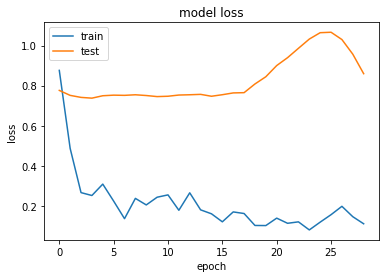

accuracy


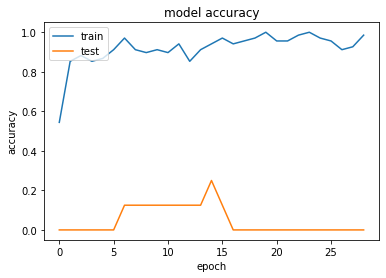

              precision    recall  f1-score    support
0              0.000000  0.000000  0.000000  20.000000
1              0.333333  1.000000  0.500000  10.000000
accuracy       0.333333  0.333333  0.333333   0.333333
macro avg      0.166667  0.500000  0.250000  30.000000
weighted avg   0.111111  0.333333  0.166667  30.000000
   0   1
0  0  20
1  0  10
AUC: 0.535
         Class  0   1
0  DUPLICATION  0  10
1  OTHER-LINKS  0  10
2    NON-LINKS  0  10
mappedtype        pred
Composition       1        2
Duplication       1       10
General Relation  1        7
Non-Link          1       10
Temporal/Causal   1        1
dtype: int64
         Class  0   1
0  DUPLICATION  0  10
1  OTHER-LINKS  0  10
2    NON-LINKS  0  10
     Dataset       ACC    AUC
0  R_test_lt  0.333333  0.535
         Class  Precision  Recall   F1
0  Duplication   0.333333     1.0  0.5
1    Non-Links   0.000000     0.0  NaN
2  Other-Links   0.000000     0.0  NaN
3         Both   0.000000     0.0  0.0


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-46-d1583daa260b>:123: RuntimeWarning: invalid value 

In [48]:
LTvNL_preds = do_model('R_LTvNL')

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 00079: early stopping
loss


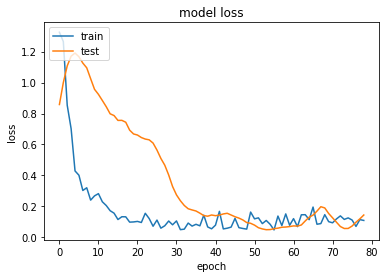

accuracy


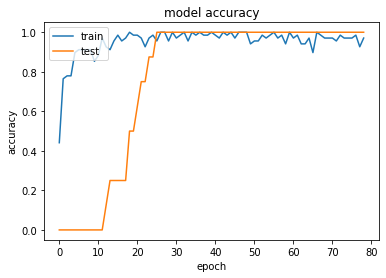

              precision    recall  f1-score    support
0              0.666667  1.000000  0.800000  20.000000
1              0.000000  0.000000  0.000000  10.000000
accuracy       0.666667  0.666667  0.666667   0.666667
macro avg      0.333333  0.500000  0.400000  30.000000
weighted avg   0.444444  0.666667  0.533333  30.000000
    0  1
0  20  0
1  10  0
AUC: 0.355
         Class   0  1
0  DUPLICATION  10  0
1  OTHER-LINKS  10  0
2    NON-LINKS  10  0
mappedtype        pred
Composition       0        2
Duplication       0       10
General Relation  0        7
Non-Link          0       10
Temporal/Causal   0        1
dtype: int64
         Class   0  1
0  DUPLICATION  10  0
1  OTHER-LINKS  10  0
2    NON-LINKS  10  0
     Dataset       ACC    AUC
0  R_test_lt  0.666667  0.355
         Class Precision  Recall        F1
0  Duplication         0     0.0       NaN
1    Non-Links       0.5     1.0  0.666667
2  Other-Links       0.5     1.0  0.666667
3         Both  0.666667     1.0  0.800000


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-46-d1583daa260b>:121: RuntimeWarning: invalid value 

In [49]:
LTvOL_preds = do_model('R_LTvOL')

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 00046: early stopping
loss


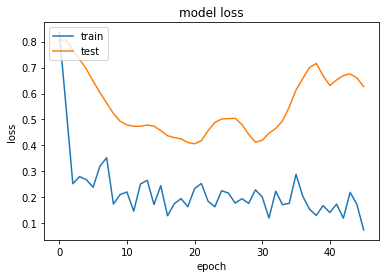

accuracy


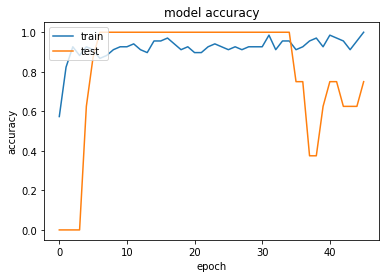

              precision    recall  f1-score    support
0              0.769231  0.500000  0.606061  20.000000
1              0.411765  0.700000  0.518519  10.000000
accuracy       0.566667  0.566667  0.566667   0.566667
macro avg      0.590498  0.600000  0.562290  30.000000
weighted avg   0.650075  0.566667  0.576880  30.000000
    0   1
0  10  10
1   3   7
AUC: 0.7050000000000001
         Class  0  1
0  DUPLICATION  3  7
1  OTHER-LINKS  5  5
2    NON-LINKS  5  5
mappedtype        pred
Composition       0       1
                  1       1
Duplication       0       3
                  1       7
General Relation  0       4
                  1       3
Non-Link          0       5
                  1       5
Temporal/Causal   1       1
dtype: int64
         Class  0  1
0  DUPLICATION  3  7
1  OTHER-LINKS  5  5
2    NON-LINKS  5  5
     Dataset       ACC    AUC
0  R_test_lt  0.566667  0.705
         Class  Precision  Recall        F1
0  Duplication   0.411765     0.7  0.518519
1    Non-Lin

In [50]:
LTvNLOL_preds = do_model('R_LTvNLOL')

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 00089: early stopping
loss


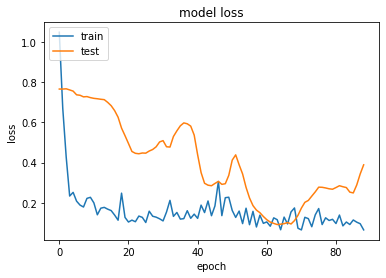

accuracy


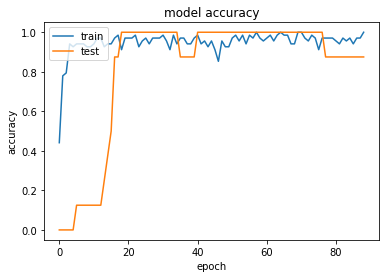

              precision  recall  f1-score  support
0              0.666667   0.200  0.307692     10.0
1              0.703704   0.950  0.808511     20.0
accuracy       0.700000   0.700  0.700000      0.7
macro avg      0.685185   0.575  0.558101     30.0
weighted avg   0.691358   0.700  0.641571     30.0
   0   1
0  2   8
1  1  19
AUC: 0.47500000000000003
         Class  0   1
0  DUPLICATION  0  10
1  OTHER-LINKS  1   9
2    NON-LINKS  2   8
mappedtype        pred
Composition       1        2
Duplication       1       10
General Relation  0        1
                  1        6
Non-Link          0        2
                  1        8
Temporal/Causal   1        1
dtype: int64
         Class  0   1
0  DUPLICATION  0  10
1  OTHER-LINKS  1   9
2    NON-LINKS  2   8
         Dataset  ACC    AUC
0  R_test_linked  0.7  0.475
         Class  Precision  Recall        F1
0  Duplication   0.555556    1.00  0.714286
1    Non-Links   0.666667    0.20  0.307692
2  Other-Links   0.529412    0.90  0.

In [51]:
LTOLvNL_preds = do_model('R_LTOLvNL')

## Statistical Significance

In [52]:
temp1 = LTvNL_preds[['name', 'label', 'pred']]
temp2 = LTOLvNL_preds[['name', 'label', 'pred']]

temp = temp1.merge(temp2, left_on='name', right_on='name', suffixes=('_1', '_2'))

In [53]:
temp['LTvNL_correct'] = temp['label_1'] == temp['pred_1']
temp['LTOLvNL_correct'] = temp['label_2'] == temp['pred_2']

In [54]:
from statsmodels.stats.contingency_tables import mcnemar

fourfield = temp[['LTvNL_correct', 'LTOLvNL_correct']].value_counts()

table = [[fourfield[True, True],  fourfield[True, False]],
        [fourfield[False, True],  fourfield[False, False]]]

result = mcnemar(table, exact=False)

print('statistic=%.10f, p-value=%.10f' % (result.statistic, result.pvalue))

alpha = 0.05
if result.pvalue > alpha:
    print('Same proportions of errors (fail to reject H0)')
else:
    print('Different proportions of errors (reject H0)')

statistic=0.7500000000, p-value=0.3864762308
Same proportions of errors (fail to reject H0)


In [55]:
mcnemar = pd.read_csv('../class_clara/experiments/Replication/results/mcnemar_latenight_sccnn.csv', index_col=0)
mcnemar.loc[SOURCE]=[result.pvalue]
mcnemar 
mcnemar.to_csv('../class_clara/experiments/Replication/results/mcnemar_latenight_sccnn.csv', encoding='utf-8', index=True)